In [79]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torchvision.transforms import transforms
from tqdm import tqdm
from PIL import ImageFilter
import torchvision.transforms.functional as TF



In [80]:
def sharpen_image(img_tensor):
    # Convert tensor to PIL Image
    img = TF.to_pil_image(img_tensor)
    # Apply the sharpen filter
    img_sharpened = img.filter(ImageFilter.SHARPEN)
    # Convert back to tensor
    img_tensor_sharpened = TF.to_tensor(img_sharpened)
    return img_tensor_sharpened

In [81]:

#subclass of torch.utils.data.Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dirs, transform=None, test=False):
        self.root_dirs = root_dirs
        self.transform = transform
        self.test = test
        self.file_list = []
        self.labels = []
        test_indices = [2, 5, 10, 11, 12, 13, 15, 39, 40, 41, 42, 44]

        if test:
            for idx in test_indices:
                for root_dir in root_dirs:
                    file_path = os.path.join(root_dir, f"{idx}.tif")
                    if os.path.exists(file_path):
                        self.file_list.append(file_path)
                        self.labels.append(0 if "B09P00" in root_dir else 1)

        else:
            for root_dir in root_dirs:
                files = sorted(os.listdir(root_dir), key=lambda x: int(x.split('.')[0]))
                for idx in files:
                    file_path = os.path.join(root_dir, idx)
                    if int(idx.split('.')[0]) not in test_indices:
                        self.file_list.append(file_path)
                        self.labels.append(0 if "B09P00" in root_dir else 1)

    def __len__(self):
        # print(self.file_list)
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        label = self.labels[index]
        image = Image.open(img_path).convert("L")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# Define the root directories where your data is stored
root_dirs = ["./YaleB/B07P00", "./YaleB/B09P00"]

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Lambda(sharpen_image), 
])

# Define the test indices
test_indices = [2, 5, 10, 11, 12, 13, 15, 39, 40, 41, 42, 44]

# # Create the custom dataset and data loader for training
# train_dataset = CustomDataset(root_dirs, transform=transform, test=False)
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


# Create the custom dataset and data loader for testing
test_dataset = CustomDataset(root_dirs, transform=transform, test=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


print(len(test_dataloader))
# print(len(train_dataloader))




24


Label: 1


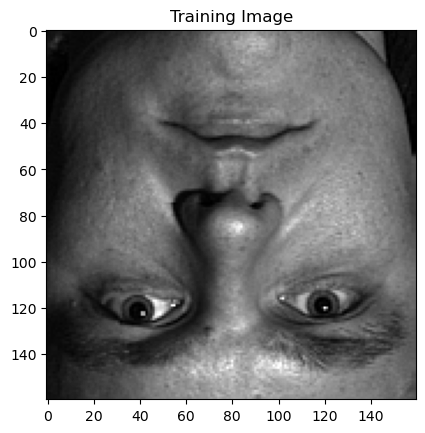

In [82]:
for images, label in test_dataloader:
    first_image = images[0].numpy().squeeze()
    print(f"Label: {label.item()}")
    # Plot the image
    plt.imshow(first_image, cmap='gray')
    plt.title("Training Image")
    plt.show()
    break  # Break after the first image

In [83]:
import torch
import torch.nn as nn

class FaceCNN(nn.Module):
    def __init__(self):
        super(FaceCNN, self).__init__()

        # Define the layers in the constructor
        self.features = nn.Sequential(
           #conv1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(4,stride = 4),
            #conv2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            #conv3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(8,stride = 8),
            nn.Flatten(1),
            #fully connected (classifier)
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,148),
            nn.ReLU(),
            nn.Linear(148,2),
            nn.Sigmoid()  # Apply sigmoid activation
        )

    def forward(self, x):
        # Define the forward pass using the layers defined in the constructor
      x = self.features(x)

      return x

cnn_model = FaceCNN()
random_input = torch.randn(1, 1, 160, 160)
output = cnn_model(random_input)
print("\nCNN Output:")
print(output)



CNN Output:
tensor([[0.4976, 0.4997]], grad_fn=<SigmoidBackward0>)


In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
learning_rate = 0.001
l2_reg = 0.001
epochs = 100


cnn_model = FaceCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=l2_reg)
train_dataset = CustomDataset(root_dirs, transform=transform, test=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


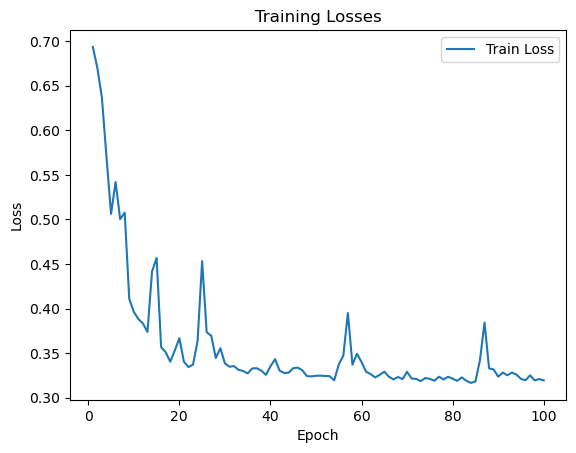

In [85]:
train_losses = []
validation_losses = []

# Training loop with validation and tqdm
for epoch in range(epochs):
    cnn_model.train()
    total_train_loss = 0.0

    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)
    cnn_model.eval()
    total_validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            total_validation_loss += loss.item()
    
    average_validation_loss = total_validation_loss / len(validation_dataloader)
    validation_losses.append(average_validation_loss)
    #print(f" Train Loss: {average_train_loss}:::::::::::::: Epoch {epoch + 1}/{epochs}:")






# Save the trained model if needed
# torch.save(cnn_model.state_dict(), "face_cnn_model.pth")

# Plot the training and  losses
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [86]:
cnn_model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for test_inputs, test_labels in tqdm(test_dataloader, desc="Testing", leave=False):
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = cnn_model(test_inputs)
        predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(test_labels.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 1.0000
Test F1 Score: 1.0000


In [87]:
all_labels


[1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]

In [88]:
all_predictions

[1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]